#### Clustering games/tags on tags co_occurence matrix

In [3]:
# import sys
# sys.path.append("..")

import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from copy import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 15 # change to set one

In [30]:
# game - tags matrix 
avis_clean = filter_df(avis_clean, min_reviews)
avis_jeux = jeux_clean[["Game id", "Type"]].merge(avis_clean[["User id", "Game id", "Rating"]], on='Game id').dropna()

# for each category create a new row
types = avis_jeux['Type'].str.split('|').explode()
user_game_type = pd.DataFrame({
    'User id': avis_jeux['User id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Game id': avis_jeux['Game id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Type': types
})

11201 10549
1640 1824
1316 1752
1304 1743
1302 1743


In [65]:
# keep only the games and tags
game_type = user_game_type[["Game id", "Type"]].drop_duplicates().pivot_table(index ="Game id", columns="Type", aggfunc='size', fill_value=0)

In [66]:
co_occ = game_type.T @ game_type #  no noramlisation

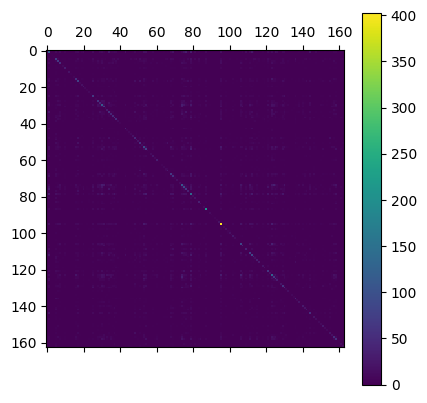

In [67]:
plt.matshow(co_occ, interpolation="none")
plt.colorbar()
plt.show()

In [68]:
# with normalisation
tag_frequencies = game_type.sum(axis=0)  # Frequency of each tag across all games, to penalize popular tags
game_type_norm = game_type.div(tag_frequencies, axis=1)
co_occ_norm = game_type_norm.T @ game_type_norm

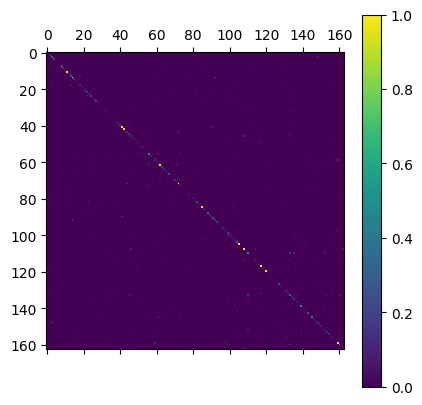

In [69]:
plt.matshow(co_occ_norm, interpolation="none")
plt.colorbar()
plt.show()

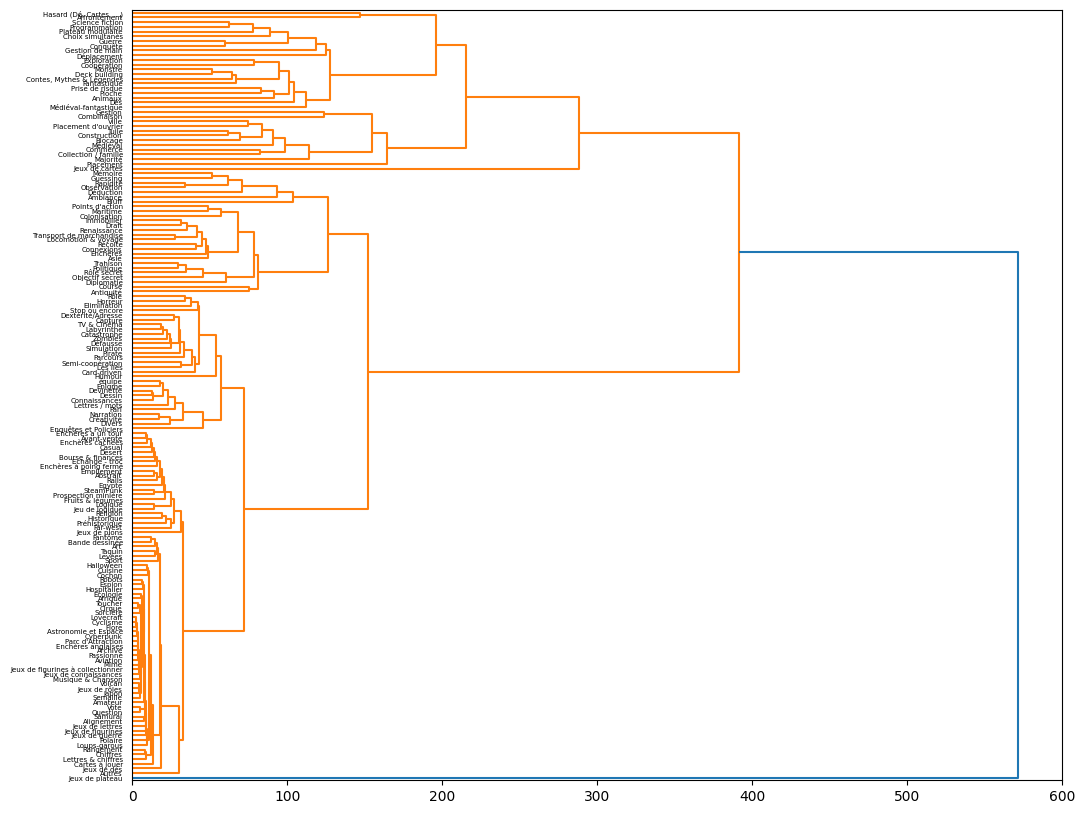

In [70]:
# co/bi clustering and hierarchical clustering on it
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

# dendogram clustering

plt.figure(figsize=(12,10))
Y = linkage(co_occ, method='ward') # clustering the categories 
_ = dendrogram(Y, orientation='right', labels=co_occ.columns) 

plt.show()

cluster  1
Index(['Abstrait', 'Afrique', 'Alignement', 'Amateur', 'Archive', 'Art',
       'Astronomie et Espace', 'Autres', 'Avant-vente', 'Aviation',
       ...
       'Sport', 'SteamPunk', 'Stop ou encore', 'TV & Cinéma', 'Taquin',
       'Toucher', 'Volcan', 'Vote', 'Zombies', 'équipe'],
      dtype='object', name='Type', length=102)
cluster  2
Index(['Ambiance', 'Antiquité', 'Asie', 'Bluff', 'Colonisation', 'Connexions',
       'Course', 'Diplomatie', 'Draft', 'Déduction', 'Enchères', 'Guessing',
       'Immobilier', 'Locomotion & voyage', 'Maritime', 'Mémoire',
       'Objectif secret', 'Observation', 'Points d'action', 'Politique',
       'Rapidité', 'Renaissance', 'Récolte', 'Rôle secret', 'Trahison',
       'Transport de marchandise'],
      dtype='object', name='Type')
cluster  3
Index(['Blocage', 'Collection / famille', 'Commerce', 'Construction',
       'Majorité', 'Médiéval', 'Placement d'ouvrier', 'Tuile', 'Ville'],
      dtype='object', name='Type')


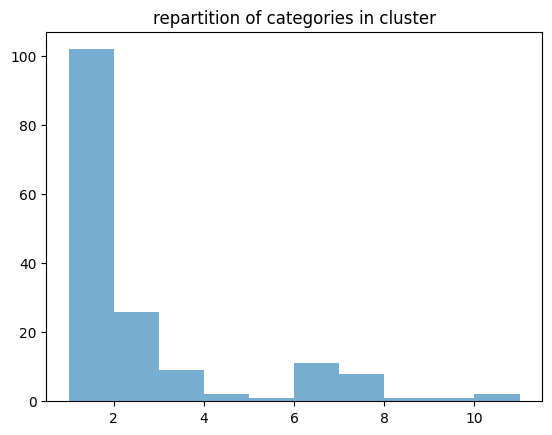

In [71]:
# apply clustering from hierarchical clustering
from scipy.cluster.hierarchy import fcluster

ncluster = 11

linkage_matrix = linkage(co_occ, method='ward')
fl = fcluster(linkage_matrix,ncluster,criterion='maxclust')
plt.title("repartition of categories in cluster")
plt.hist(fl, alpha = 0.6)

for i in range(1, 4):
    print("cluster ", i)
    print(co_occ.index[np.where(fl == i)[0]])

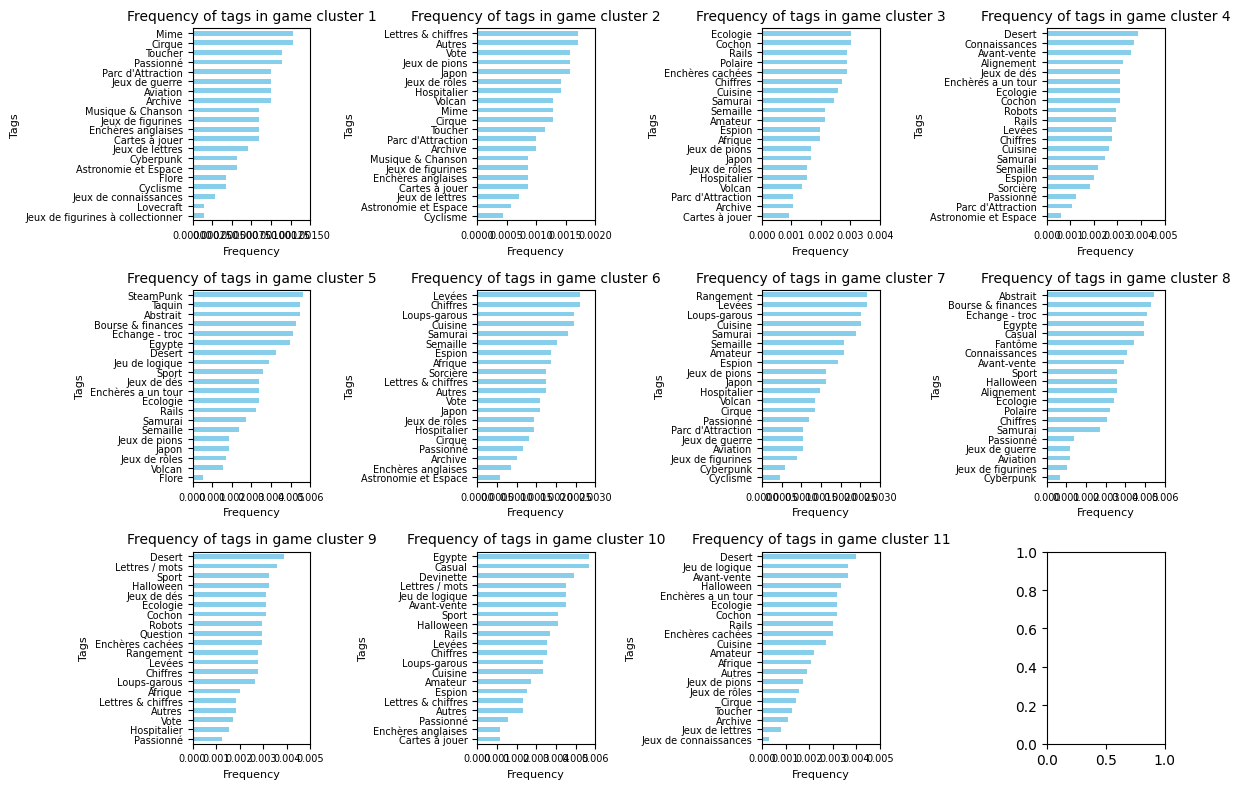

In [83]:
# hierarchical clustering, categories of clustered games

ncluster = 11

linkage_matrix = linkage(co_occ, method='ward')
fl = fcluster(linkage_matrix,ncluster,criterion='maxclust')

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
clust = 1

for i in range(3):
    for j in range(4):
        if clust > max(fl):
            break
        
        ax = axes[i, j]  # Get the axis for each subplot
        
        # Filter the DataFrame based on the current value of fl
        cluster_cat = co_occ.loc[:, (co_occ.loc[co_occ.index[np.where(fl == clust)]] != 0).any(axis=0)] # tags of games in the cluster
        
        # Calculate the frequency of tags in the current cluster
        most_pop_clusters = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison"]
        cluster_cat = cluster_cat.drop(columns = most_pop_clusters, errors='ignore')
        
        tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

        # Plot the frequency of 10 largest (case too much tags)
        tag_frequency.nsmallest(20).plot(kind='barh', color='skyblue', ax=ax) 
        
        # Set the title and axis labels with appropriate fontsize
        ax.set_title(f'Frequency of tags in game cluster {clust}', fontsize=10)
        ax.set_xlabel('Frequency', fontsize=8) 
        ax.set_ylabel('Tags', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_xticks(ax.get_xticks())

        clust += 1

plt.tight_layout()
plt.show()

Visualisation on Bi/Coclustering

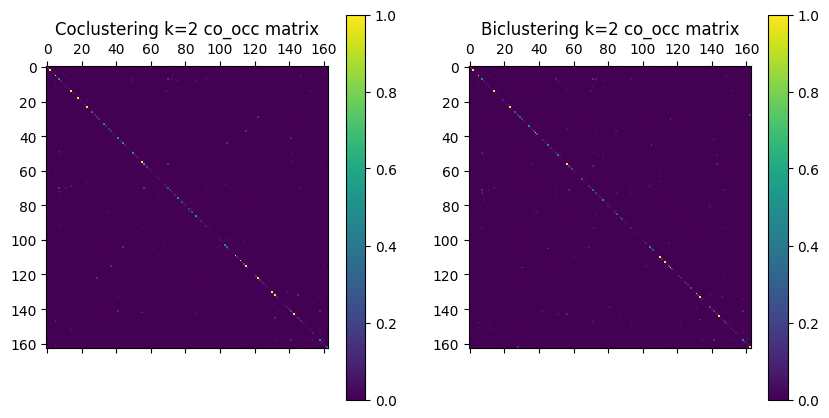

In [ ]:
# Bi/Coclustering visualisation
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

fig, ax = plt.subplots(1,2, figsize=(10, 5))

# Co clustering
clustering = SpectralCoclustering(n_clusters=2, random_state=0).fit(co_occ)
# group the clusters
reordered_rows = co_occ.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[0].matshow(reordered_data)
ax[0].set_title("Coclustering k=2 co_occ matrix")
fig.colorbar(cax, ax=ax[0])

# Bi clustering
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(co_occ)
# group the clusters
reordered_rows = co_occ.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[1].matshow(reordered_data)
ax[1].set_title("Biclustering k=2 co_occ matrix")
fig.colorbar(cax, ax=ax[1])

plt.subplots_adjust() 
plt.show()

# nothing significant